In [1]:
import operator
from typing import Callable

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import polars as pl
from polars import selectors as cs
import seaborn as sns
from scipy import stats

from lib import (
    binned,
    compute_correlation_matrix,
    load_dataset,
    compute_accuracy_results,
    process_parameter_dataset,
    compute_runtime_validity_results,
    process_runtime_dataset,
    set_legend_line_width,
    make_boxplot,
    validate_parameter_dataset,
    apply_hypothesis_test,
    save_figure,
    save_table,
    normalized,
    format_network_types,
    fit_runtime_model,
    get_runtime_model_data,
    compute_percentiles,
)

In [2]:
pl.Config.set_tbl_rows(100);
pl.Config.set_fmt_str_lengths(40);

## Experiment 1: Parameters

In [3]:
# Ref: https://en.wikipedia.org/wiki/Seven-number_summary#Bowley%E2%80%99s_seven-figure_summary
seven_number_summary_percentiles = [0, 10, 25, 50, 75, 90, 100]

In [4]:
df = load_dataset("send-coefficient")
validate_parameter_dataset(df)

In [5]:
accuracy_results = compute_accuracy_results(
    process_parameter_dataset(df),
    parameter="send_coefficient",
    tabular_percentiles=[0, 0.01, 0.1, *range(1, 7), 21],
    count_percentiles=seven_number_summary_percentiles,
)

min_parameter = accuracy_results.counts["send_coefficient"].min()


def filter_min_parameter(_df: pl.DataFrame, op: Callable) -> pl.DataFrame:
    return _df.filter(op(pl.col("send_coefficient"), min_parameter))

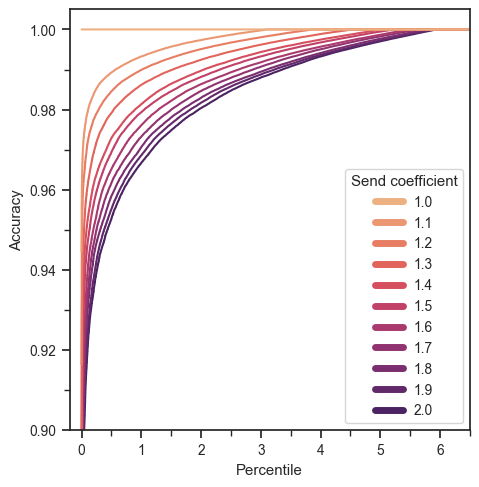

In [38]:
data = filter_min_parameter(accuracy_results.tabular, operator.ge)

g = sns.displot(
    data,
    kind="ecdf",
    y="accuracy",
    hue="send_coefficient",
    palette="flare",
    stat="percent",
    facet_kws={"legend_out": False},
)

g.set_axis_labels("Percentile", "Accuracy")
g.set(xlim=(-0.2, 6.5), ylim=(0.90, 1.005))
g.ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.01))
g.ax.xaxis.set_minor_locator(ticker.MultipleLocator(0.5))
g.legend.set_title("Send coefficient")

set_legend_line_width(g, 5)

sns.set_theme(style="ticks", font_scale=0.9)
sns.despine(top=False, right=False, left=False, bottom=False)

output_path = "outputs/accuracy-percentiles"
save_figure(output_path)
save_table(accuracy_results.tabular_percentiles.aggregate, output_path)

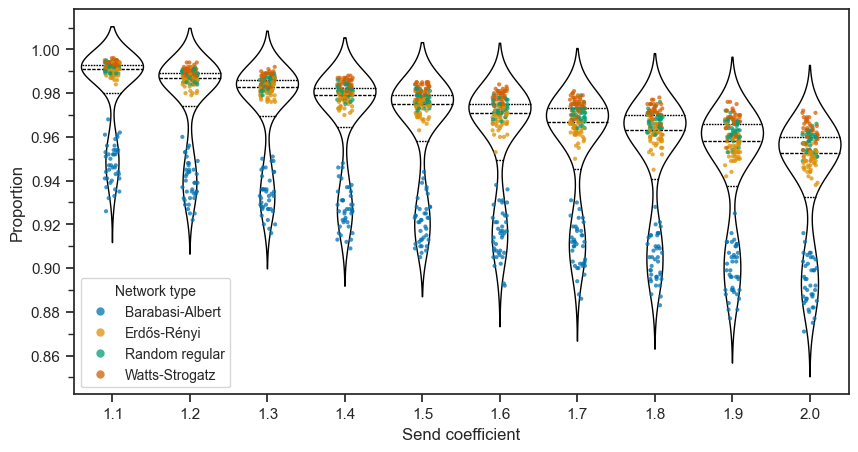

In [62]:
data = filter_min_parameter(accuracy_results.counts, operator.gt)
data = format_network_types(data)

plt.figure(figsize=(10, 5))

ax = sns.violinplot(
    data,
    x="send_coefficient",
    y="proportion",
    color="black",
    linewidth=1,
    fill=None,
    inner="quart",
    gridsize=1000,
    density_norm="width",
)

ax = sns.stripplot(
    data,
    x="send_coefficient",
    y="proportion",
    size=3,
    hue="network_type",
    palette="colorblind",
    alpha=0.75,
)

ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.01))
ax.xaxis.set_label_text("Send coefficient")
ax.yaxis.set_label_text("Proportion")

sns.set_theme(style="ticks", font_scale=1)
sns.despine(top=False, right=False, left=False, bottom=False)

plt.legend(title="Network type", fontsize='small', title_fontsize='small', markerscale=2)

output_path = "outputs/accuracy-proportions"
save_figure(output_path)
save_table(accuracy_results.count_percentiles.aggregate, output_path)

In [108]:
# data = filter_min_parameter(accuracy_results.counts, operator.gt)

# sns.set_theme(style="ticks", font_scale=1.5)

# g = make_boxplot(data, x="send_coefficient", y="proportion", sharey=False, by_network_type=True)

# g.set_axis_labels("Send coefficient", "Proportion")

# output_path = "outputs/accuracy_lifted_network-type"
# save_figure(output_path)
# save_table(format_network_types(results.count_percentiles.network_type), output_path)

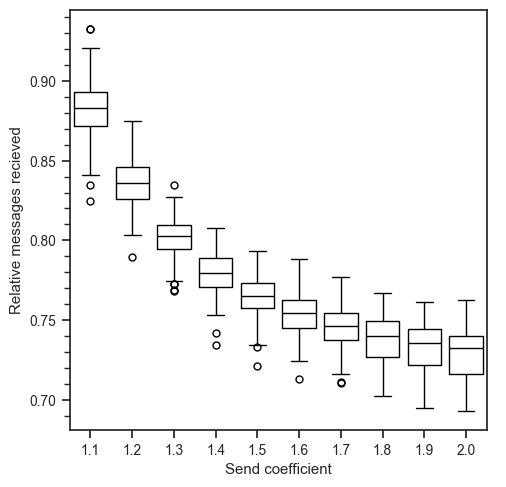

In [60]:
data = filter_min_parameter(df, operator.ge)

data = data.with_columns(pl.col("n_receives").list.sum()).with_columns(
    normalized("n_receives", by="max")
    .over("dataset_id", "network_id", "score_source")
    .alias("normalized_n_receives")
)

g = make_boxplot(
    data.filter(pl.col("send_coefficient") > min_parameter).to_pandas(),
    x="send_coefficient",
    y="normalized_n_receives",
)

g.ax.yaxis.set_major_locator(ticker.MultipleLocator(0.05))
g.ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.01))
g.set_axis_labels("Send coefficient", "Relative messages recieved")

sns.set_theme(style="ticks", font_scale=0.9)
sns.despine(top=False, right=False, left=False, bottom=False)

table = compute_percentiles(
    data,
    axes=["send_coefficient"],
    col="normalized_n_receives",
    percentiles=seven_number_summary_percentiles,
)

save_figure("outputs/relative-receives")

In [ ]:
save_table(table, "outputs/relative-receives")

table

In [59]:
# data = filter_min_parameter(df, operator.ge)
# data = process_parameter_dataset(data)

# g = sns.displot(
#     data,
#     kind="hist",
#     x="msg_reachability",
#     col=parameter,
#     col_wrap=3,
#     discrete=True,
#     stat="proportion",
#     binrange=(0, 4),
#     fill=False,
#     color="black",
#     common_norm=False,
# )

# g.set_titles(col_template=f"${parameter_symbol} = {{col_name}}$")

# # Ref: https://stackoverflow.com/a/67561982
# for ax in g.axes.flat:
#     ax.bar_label(ax.containers[0], fmt="%.2f", padding=2)
#     ax.margins(y=0.2)

# save_figure("outputs/message-reachability-trellis")

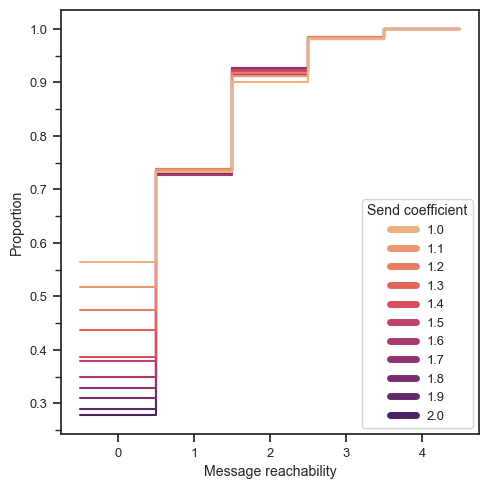

In [10]:
data = filter_min_parameter(df, operator.ge)
data = process_parameter_dataset(data)

data = data.sample(fraction=0.01)

g = sns.displot(
    data,
    kind="hist",
    x="msg_reachability",
    stat="proportion",
    hue="send_coefficient",
    discrete=True,
    cumulative=True,
    binrange=(0, 4),
    fill=False,
    element="step",
    common_norm=False,
    palette="flare",
    facet_kws={"legend_out": False},
)

g.set_xlabels("Message reachability")
g.ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
g.ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.05))
g.legend.set_title("Send coefficient")

set_legend_line_width(g, 5)

sns.set_theme(style="ticks", font_scale=0.85)
sns.despine(top=False, right=False, left=False, bottom=False)

save_figure("outputs/message-reachability")

In [7]:
data = filter_min_parameter(df, operator.ge)
data = process_parameter_dataset(data)

results = compute_percentiles(data, col="msg_reachability", percentiles=[25, 50, 75, 90, 95, 99, 99.9, 99.99, 100])

results = results.with_columns(cs.all().cast(pl.Int64))

save_table(results, "outputs/message-reachability")

results

$P_{25}$,$P_{50}$,$P_{75}$,$P_{90}$,$P_{95}$,$P_{99}$,$P_{99.9}$,$P_{99.99}$,$P_{100}$
i64,i64,i64,i64,i64,i64,i64,i64,i64
0,1,2,2,3,4,5,7,9


In [ ]:
data = filter_min_parameter(df, operator.ge)
data = data.filter(pl.col('network_type') != 'RandomRegular')
data = process_parameter_dataset(data)
data = format_network_types(data)

g = sns.displot(
    data,
    x="n_contacts",
    hue="network_type",
    kind="hist",
    stat="proportion",
    element="step",
    discrete=True,
    common_norm=False,
    facet_kws={'xlim': (0, 50), "legend_out": False},
    palette="colorblind",
);

g.ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
g.ax.xaxis.set_minor_locator(ticker.MultipleLocator(5))
g.ax.yaxis.set_major_locator(ticker.MultipleLocator(0.05))
g.ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.01))
g.ax.set_xlabel("Degree")
g.legend.set_title("Network type")

sns.set_theme(style="ticks", font_scale=0.85)
sns.despine(top=False, right=False, left=False, bottom=False)

save_figure("outputs/network-degree-distributions")

In [ ]:
data = filter_min_parameter(df, operator.ge)
data = process_parameter_dataset(data)
data = format_network_types(data)

results = compute_percentiles(
    data, 
    axes=["network_type"], 
    col="n_contacts",
    percentiles=seven_number_summary_percentiles)

save_table(results, "outputs/network-degree-percentiles")

results

In [ ]:
data = filter_min_parameter(df, operator.ge)
data = process_parameter_dataset(data)
corr_matrix, corr_stats = compute_correlation_matrix(data, {
    "exposure_score": "Exposure score",
    "msg_reachability": "Message reachability",
    "n_contacts": "Contacts",
    "n_influences": "Influences",
    "n_receives": "Receives",
    "n_influenced": "Influenced",
    "n_updates": "Updates",
    "score_diff": "Score difference",
})

In [ ]:
corr_stats

In [ ]:
ax = sns.heatmap(
    corr_matrix,
    mask=np.triu(np.ones_like(corr_matrix, dtype=bool)),
    annot=True,
    fmt=".2f",
    linewidths=0.5,
    cmap=sns.color_palette("vlag", as_cmap=True),
    vmin=-1,
    vmax=1,
    square=True,
)

ax.set(xlabel="", ylabel="")

sns.set_theme(style="ticks", font_scale=0.85)

save_figure("outputs/correlation")

## Experiment 2: Runtime baseline

In [205]:
df = load_dataset("runtime-baseline")
df = process_runtime_dataset(df)

In [80]:
results = compute_runtime_validity_results(df)

data = format_network_types(results.total_runtime)

print("total_runtime")
print(data)

data = format_network_types(results.msg_runtime)

print("msg_runtime")
print(data)

total_runtime
shape: (4, 3)
┌─────────────────┬───────┬────────────┐
│ network_type    ┆ count ┆ proportion │
│ ---             ┆ ---   ┆ ---        │
│ str             ┆ u32   ┆ f64        │
╞═════════════════╪═══════╪════════════╡
│ Barabasi-Albert ┆ 40    ┆ 1.0        │
│ Erdős-Rényi     ┆ 40    ┆ 1.0        │
│ Random regular  ┆ 40    ┆ 1.0        │
│ Watts-Strogatz  ┆ 40    ┆ 1.0        │
└─────────────────┴───────┴────────────┘
msg_runtime
shape: (4, 3)
┌─────────────────┬───────┬────────────┐
│ network_type    ┆ count ┆ proportion │
│ ---             ┆ ---   ┆ ---        │
│ str             ┆ u32   ┆ f64        │
╞═════════════════╪═══════╪════════════╡
│ Barabasi-Albert ┆ 40    ┆ 1.0        │
│ Erdős-Rényi     ┆ 40    ┆ 1.0        │
│ Random regular  ┆ 40    ┆ 1.0        │
│ Watts-Strogatz  ┆ 40    ┆ 1.0        │
└─────────────────┴───────┴────────────┘


In [81]:
apply_hypothesis_test(df, stats.shapiro, by_distributions=True)

ShapiroResult(statistic=0.67198017890183, pvalue=2.042930122606384e-17)

In [82]:
apply_hypothesis_test(df, stats.shapiro, by_distributions=True, by_network_type=True)

{'BarabasiAlbert': ShapiroResult(statistic=0.6455841858114166, pvalue=1.3871243031399161e-08),
 'GnmRandom': ShapiroResult(statistic=0.4722427270825328, pvalue=8.131432237889303e-11),
 'RandomRegular': ShapiroResult(statistic=0.5834436164177581, pvalue=1.872371357241384e-09),
 'WattsStrogatz': ShapiroResult(statistic=0.43728166802888524, pvalue=3.332332165092599e-11)}

In [83]:
apply_hypothesis_test(df, stats.fligner, by_distributions=True)

FlignerResult(statistic=2.276324912275613, pvalue=0.9429784063064717)

In [84]:
apply_hypothesis_test(df, stats.fligner, by_distributions=True, by_network_type=True)

{'BarabasiAlbert': FlignerResult(statistic=4.608714192501368, pvalue=0.7075897925246313),
 'GnmRandom': FlignerResult(statistic=4.877621552929999, pvalue=0.6748947081529908),
 'RandomRegular': FlignerResult(statistic=3.971899028233329, pvalue=0.7830083542754536),
 'WattsStrogatz': FlignerResult(statistic=2.268505908520036, pvalue=0.9434980918897997)}

In [85]:
apply_hypothesis_test(df, stats.kruskal, by_distributions=True)

KruskalResult(statistic=7.030418187414728, pvalue=0.425719618877831)

In [86]:
apply_hypothesis_test(df, stats.kruskal, by_distributions=True, by_network_type=True)

{'BarabasiAlbert': KruskalResult(statistic=5.240544856740269, pvalue=0.63063439449162),
 'GnmRandom': KruskalResult(statistic=3.2309255079007024, pvalue=0.8628497317188233),
 'RandomRegular': KruskalResult(statistic=3.0218591549295746, pvalue=0.8829727404160843),
 'WattsStrogatz': KruskalResult(statistic=5.9706147772138, pvalue=0.5431846923466834)}

## Experiment 3: Runtime

In [11]:
df = load_dataset("runtime")
df = process_runtime_dataset(df)

In [12]:
results = compute_runtime_validity_results(df)

data = format_network_types(results.total_runtime)

print("total_runtime")
print(data)

data = format_network_types(results.msg_runtime)

print("msg_runtime")
print(data)

# save_table(data, "outputs/runtime-validity")

total_runtime
shape: (4, 3)
┌─────────────────┬───────┬────────────┐
│ network_type    ┆ count ┆ proportion │
│ ---             ┆ ---   ┆ ---        │
│ str             ┆ u32   ┆ f64        │
╞═════════════════╪═══════╪════════════╡
│ Barabasi-Albert ┆ 484   ┆ 0.968      │
│ Erdős-Rényi     ┆ 491   ┆ 0.982      │
│ Random regular  ┆ 493   ┆ 0.986      │
│ Watts-Strogatz  ┆ 487   ┆ 0.974      │
└─────────────────┴───────┴────────────┘
msg_runtime
shape: (4, 3)
┌─────────────────┬───────┬────────────┐
│ network_type    ┆ count ┆ proportion │
│ ---             ┆ ---   ┆ ---        │
│ str             ┆ u32   ┆ f64        │
╞═════════════════╪═══════╪════════════╡
│ Barabasi-Albert ┆ 500   ┆ 1.0        │
│ Erdős-Rényi     ┆ 500   ┆ 1.0        │
│ Random regular  ┆ 500   ┆ 1.0        │
│ Watts-Strogatz  ┆ 500   ┆ 1.0        │
└─────────────────┴───────┴────────────┘


In [89]:
# invalid = df.filter(total_runtime_validity=False)

In [90]:
# data = binned(invalid, col="n_nodes", scale=10_000, rescale=10)
# data = format_network_types(data)

# sns.set_theme(style="ticks", font_scale=1.25)

# g = sns.displot(
#     data,
#     kind="hist",
#     stat="count",
#     x="network_type",
#     hue="binned_n_nodes",
#     discrete=True,
#     multiple="stack",
#     aspect=1.5,
#     palette="rocket",
#     shrink=0.9,
# )

# g.set_axis_labels("Network type", "Count")
# g.ax.yaxis.set_minor_locator(ticker.MultipleLocator(1))

# g.legend.set_title("Vertices (thousands)")

# save_figure("outputs/invalid_nodes")

In [91]:
# data = binned(invalid, col="n_edges", scale=1_000_000, rescale=False)
# data = format_network_types(data)

# sns.set_theme(style="ticks", font_scale=1.25)

# g = sns.displot(
#     data,
#     kind="hist",
#     stat="count",
#     x="network_type",
#     hue="binned_n_edges",
#     discrete=True,
#     multiple="stack",
#     aspect=1.5,
#     palette="rocket",
#     shrink=0.9,
# )

# g.set_axis_labels("Network type", "Count")
# g.ax.yaxis.set_minor_locator(ticker.MultipleLocator(1))
# g.legend.set_title("Edges (millions)")

# save_figure("outputs/invalid_edges")

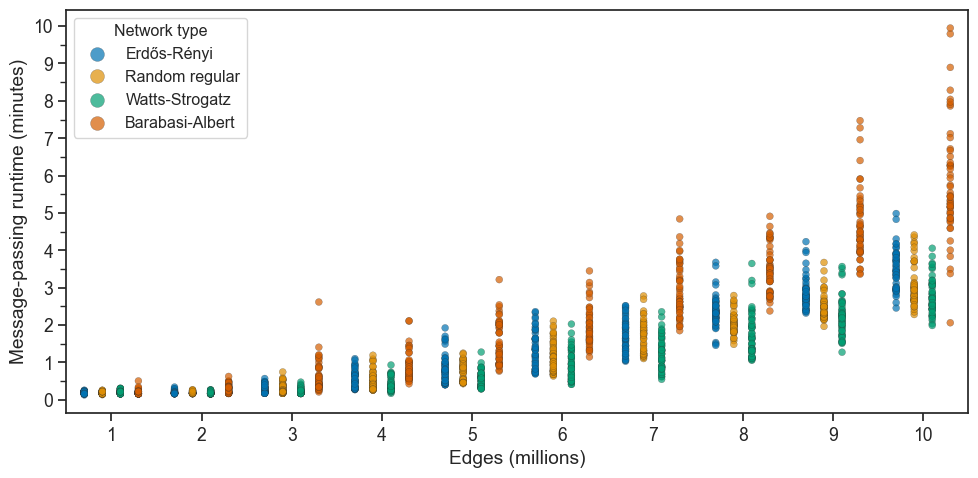

In [29]:
data = binned(df, col="n_edges", scale=1_000_000, rescale=False)
data = data.with_columns(pl.col("msg_runtime") / 60)
data = format_network_types(data)

g = sns.catplot(
    data,
    x="binned_n_edges",
    y="msg_runtime",
    hue="network_type",
    kind="strip",
    dodge=True,
    jitter=0,
    palette="colorblind",
    linewidth=0.2,
    alpha=0.7,
    legend_out=False,
    aspect=2,
)
g.ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
g.ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.5))
g.set_axis_labels("Edges (millions)", "Message-passing runtime (minutes)")

plt.legend(title="Network type", fontsize='small', title_fontsize='small', markerscale=2)

sns.set_theme(style="ticks", font_scale=1.15)
sns.despine(top=False, right=False, left=False, bottom=False)

save_figure("outputs/runtimes")

**Theory:** Barabasi-Albert contact networks have worse message-passing runtime because the degree distribution is extremely skewed. Actors are single-threaded, actors with a high number of contacts inhibits concurrency.

In [30]:
estimators, results = fit_runtime_model(df, quantiles=(0.05, 0.5, 0.95), seed=12345)
results = results.select(pl.col("*").round_sig_figs(3))

In [94]:
save_table(results, "outputs/runtime-regression")
results

quantile,intercept,coefficient,alpha,pinball_loss_mean,pinball_loss_std_err,d2_pinball_score_mean,d2_pinball_score_std_err
f64,f64,f64,f64,f64,f64,f64,f64
0.05,-34.1,0.0000125,0.1,-2.94,0.0469,0.255,0.011
0.5,-29.7,0.0000199,0.1,-15.6,0.362,0.52,0.00851
0.95,-21.7,0.0000348,0.1,-5.91,0.299,0.496,0.0181


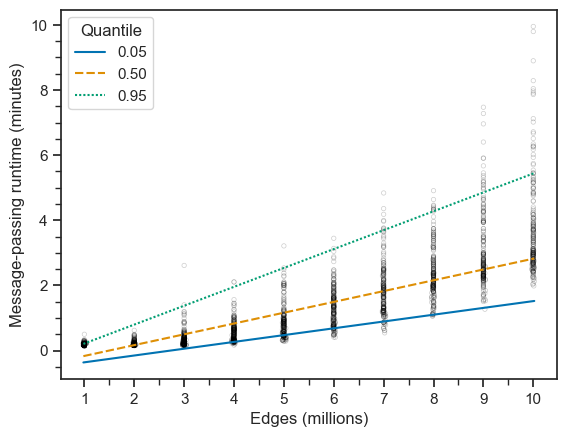

In [38]:
x_true, y_true = get_runtime_model_data(df, flatten=True)

x_scale = 1 / 1_000_000
y_scale = 1 / 60

sns.scatterplot(
    x=x_true * x_scale,
    y=y_true * y_scale,
    edgecolor="black",
    facecolor="none",
    linewidth=0.5,
    s=10,
    alpha=0.2,
)

x_pred = np.linspace(x_true.min(), x_true.max(), 10_000).reshape(-1, 1)

plot_data = pl.concat(
    [
        pl.DataFrame(
            {
                "x": x_pred.flatten() * x_scale,
                "y": estimator.predict(x_pred) * y_scale,
                "quantile": ["{0:.2f}".format(quantile)] * len(x_pred),
            }
        )
        for quantile, estimator in estimators.items()
    ]
)

ax = sns.lineplot(
    data=plot_data,
    x="x",
    y="y",
    hue="quantile",
    palette="colorblind",
    linewidth=1.5,
    style="quantile",
)

ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(0.5))
ax.yaxis.set_major_locator(ticker.MultipleLocator(2))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.5))
ax.set_xlabel("Edges (millions)")
ax.set_ylabel("Message-passing runtime (minutes)")
ax.legend_.set_title("Quantile")

sns.set_theme(style="ticks", font_scale=1)
sns.despine(top=False, right=False, left=False, bottom=False)

save_figure("outputs/runtime-regression")